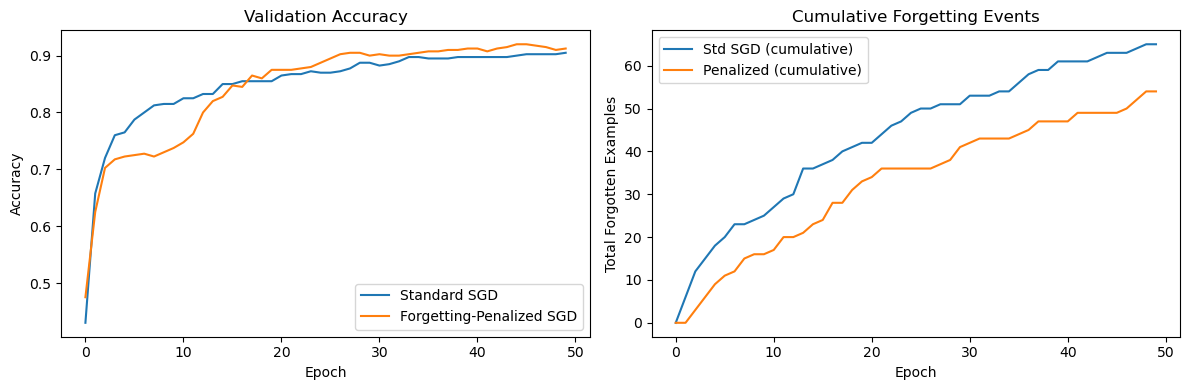

Total forgetting: Baseline=65, Penalized=54


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Data: Simple 2D binary classification
X, y = make_classification(n_samples=2000, n_features=6, n_informative=4, n_redundant=2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return torch.sigmoid(self.net(x)).squeeze()

def run_training(penalty_lambda=0.0, epochs=50):
    model = MLP(X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()
    prev_val_correct = None
    forgetting_events = []
    val_accs = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        # Eval on validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_pred_labels = (y_val_pred > 0.5).float()
            val_correct = (val_pred_labels == y_val).float()
            val_acc = val_correct.mean().item()
            val_accs.append(val_acc)
            # Compute forgetting: how many correct last time, now wrong
            if prev_val_correct is None:
                forgetting = 0
            else:
                forgetting = int(((prev_val_correct == 1) & (val_correct == 0)).sum().item())
            forgetting_events.append(forgetting)
            prev_val_correct = val_correct.clone()
        # Add forgetting penalty if requested
        total_loss = loss + penalty_lambda * forgetting
        total_loss.backward()
        optimizer.step()
    return val_accs, forgetting_events

# Run both models
val_acc_std, forget_std = run_training(penalty_lambda=0.0)
val_acc_pen, forget_pen = run_training(penalty_lambda=2.0)  # Try λ=2; tune for effect

# Plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(val_acc_std, label="Standard SGD")
plt.plot(val_acc_pen, label="Forgetting-Penalized SGD")
plt.title("Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.cumsum(forget_std), label="Std SGD (cumulative)")
plt.plot(np.cumsum(forget_pen), label="Penalized (cumulative)")
plt.title("Cumulative Forgetting Events")
plt.xlabel("Epoch"); plt.ylabel("Total Forgotten Examples")
plt.legend()
plt.tight_layout()
plt.show()
print(f"Total forgetting: Baseline={sum(forget_std)}, Penalized={sum(forget_pen)}")


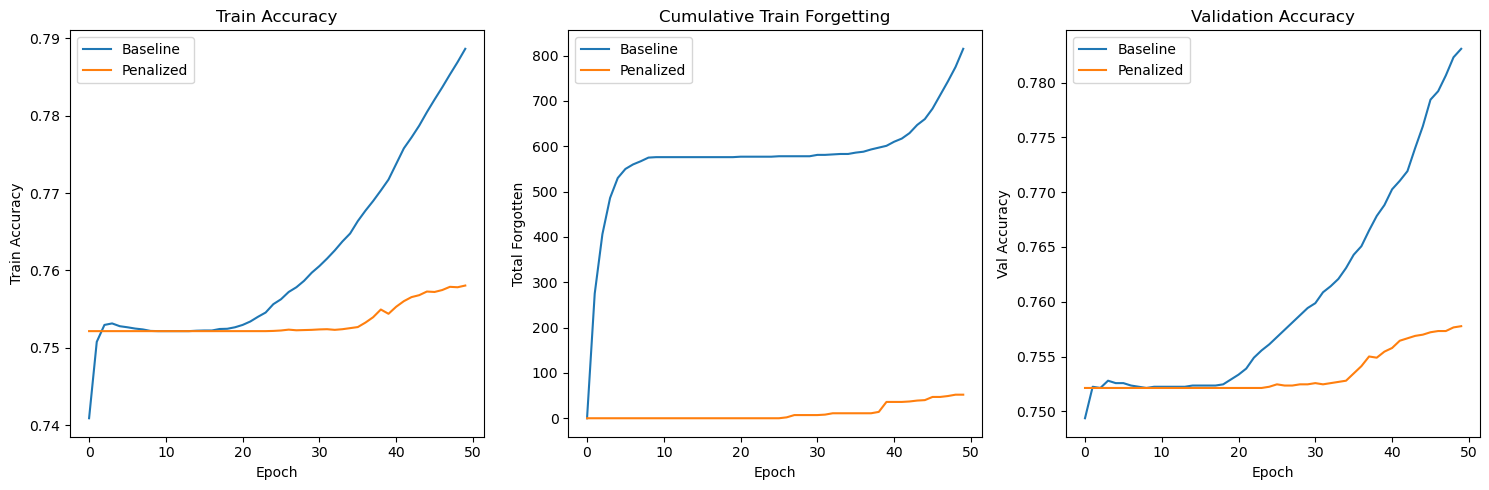


Total forgetting (train set):
  Baseline:        815
  Penalized:       52

Final train accuracy:
  Baseline:        0.789
  Penalized:       0.758

Final validation accuracy:
  Baseline:        0.783
  Penalized:       0.758


In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Load Adult Data ---
def load_adult():
    data = fetch_openml("adult", version=2, as_frame=True)
    df = data.frame.dropna()
    X = pd.get_dummies(df.drop('class', axis=1))
    y = (df['class'] == '>50K').astype(int)
    X = X.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    return (torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(X_val, dtype=torch.float32),
            torch.tensor(y_train.values, dtype=torch.float32),
            torch.tensor(y_val.values, dtype=torch.float32))

X_train, X_val, y_train, y_val = load_adult()

# --- Model ---
class MLP(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(D, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): 
        return torch.sigmoid(self.net(x)).squeeze()

# --- Baseline Training ---
def run_training_baseline(epochs=50):
    model = MLP(X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    loss_fn = nn.BCELoss()
    train_accs, forgetting_events, val_accs = [], [], []
    prev_train_correct = None
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        train_pred_labels = (y_pred > 0.5).float()
        train_correct = (train_pred_labels == y_train).float()
        train_accs.append(train_correct.mean().item())
        # Forgetting: correct→incorrect transitions
        if prev_train_correct is None:
            forgetting = 0
        else:
            forgetting = int(((prev_train_correct == 1) & (train_correct == 0)).sum().item())
        forgetting_events.append(forgetting)
        prev_train_correct = train_correct.clone()
        # Backprop
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        # Validation accuracy
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_pred_labels = (y_val_pred > 0.5).float()
            val_acc = (val_pred_labels == y_val).float().mean().item()
            val_accs.append(val_acc)
    return train_accs, forgetting_events, val_accs

# --- Penalized Training (Forgetting on Training Set) ---
def run_training_forgetting_penalized_on_train(
    base_penalty=0.1, max_penalty=0.5, warmup_epochs=10, epochs=50
):
    model = MLP(X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    loss_fn = nn.BCELoss()
    prev_train_correct = None
    ever_forgotten = torch.zeros_like(y_train)
    train_accs, forgetting_events, val_accs = [], [], []
    for epoch in range(epochs):
        # ADAPTIVE penalty schedule
        if epoch < warmup_epochs:
            penalty_lambda = 0.0
        else:
            progress = (epoch - warmup_epochs) / max(1, (epochs - warmup_epochs))
            penalty_lambda = base_penalty + (max_penalty - base_penalty) * progress

        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        train_pred_labels = (y_pred > 0.5).float()
        train_correct = (train_pred_labels == y_train).float()
        train_accs.append(train_correct.mean().item())
        # Forgetting: correct→incorrect transitions on train set
        if prev_train_correct is None:
            forgetting = 0
            forget_mask = None
        else:
            forget_mask = ((prev_train_correct == 1) & (train_correct == 0) & (ever_forgotten == 0))
            forgetting = int(forget_mask.sum().item())
        forgetting_events.append(forgetting)
        # Update ever_forgotten
        if prev_train_correct is not None and forget_mask is not None:
            ever_forgotten = ever_forgotten.clone()
            ever_forgotten[forget_mask] = 1
        # Penalize forgetting on train set
        forget_penalty = torch.tensor(0.0)
        if (
            prev_train_correct is not None
            and forget_mask is not None
            and forget_mask.sum() > 0
            and penalty_lambda > 0
        ):
            forget_penalty = loss_fn(y_pred[forget_mask], y_train[forget_mask])
            total_loss = loss_fn(y_pred, y_train) + penalty_lambda * forget_penalty
        else:
            total_loss = loss_fn(y_pred, y_train)
        total_loss.backward()
        optimizer.step()
        prev_train_correct = train_correct.clone()
        # Validation accuracy
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_pred_labels = (y_val_pred > 0.5).float()
            val_acc = (val_pred_labels == y_val).float().mean().item()
            val_accs.append(val_acc)
    return train_accs, forgetting_events, val_accs

# --- Run Both ---
epochs = 50
train_acc_base, forget_base, val_acc_base = run_training_baseline(epochs=epochs)
train_acc_pen, forget_pen, val_acc_pen = run_training_forgetting_penalized_on_train(
    base_penalty=0.1, max_penalty=0.5, warmup_epochs=20, epochs=epochs
)

# --- Plot Results ---
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(train_acc_base, label="Baseline")
plt.plot(train_acc_pen, label="Penalized")
plt.title("Train Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Train Accuracy"); plt.legend()
plt.subplot(1,3,2)
plt.plot(np.cumsum(forget_base), label="Baseline")
plt.plot(np.cumsum(forget_pen), label="Penalized")
plt.title("Cumulative Train Forgetting")
plt.xlabel("Epoch"); plt.ylabel("Total Forgotten"); plt.legend()
plt.subplot(1,3,3)
plt.plot(val_acc_base, label="Baseline")
plt.plot(val_acc_pen, label="Penalized")
plt.title("Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy"); plt.legend()
plt.tight_layout()
plt.show()

# --- Print Summary ---
print("\nTotal forgetting (train set):")
print(f"  Baseline:        {sum(forget_base)}")
print(f"  Penalized:       {sum(forget_pen)}")
print(f"\nFinal train accuracy:")
print(f"  Baseline:        {train_acc_base[-1]:.3f}")
print(f"  Penalized:       {train_acc_pen[-1]:.3f}")
print(f"\nFinal validation accuracy:")
print(f"  Baseline:        {val_acc_base[-1]:.3f}")
print(f"  Penalized:       {val_acc_pen[-1]:.3f}")

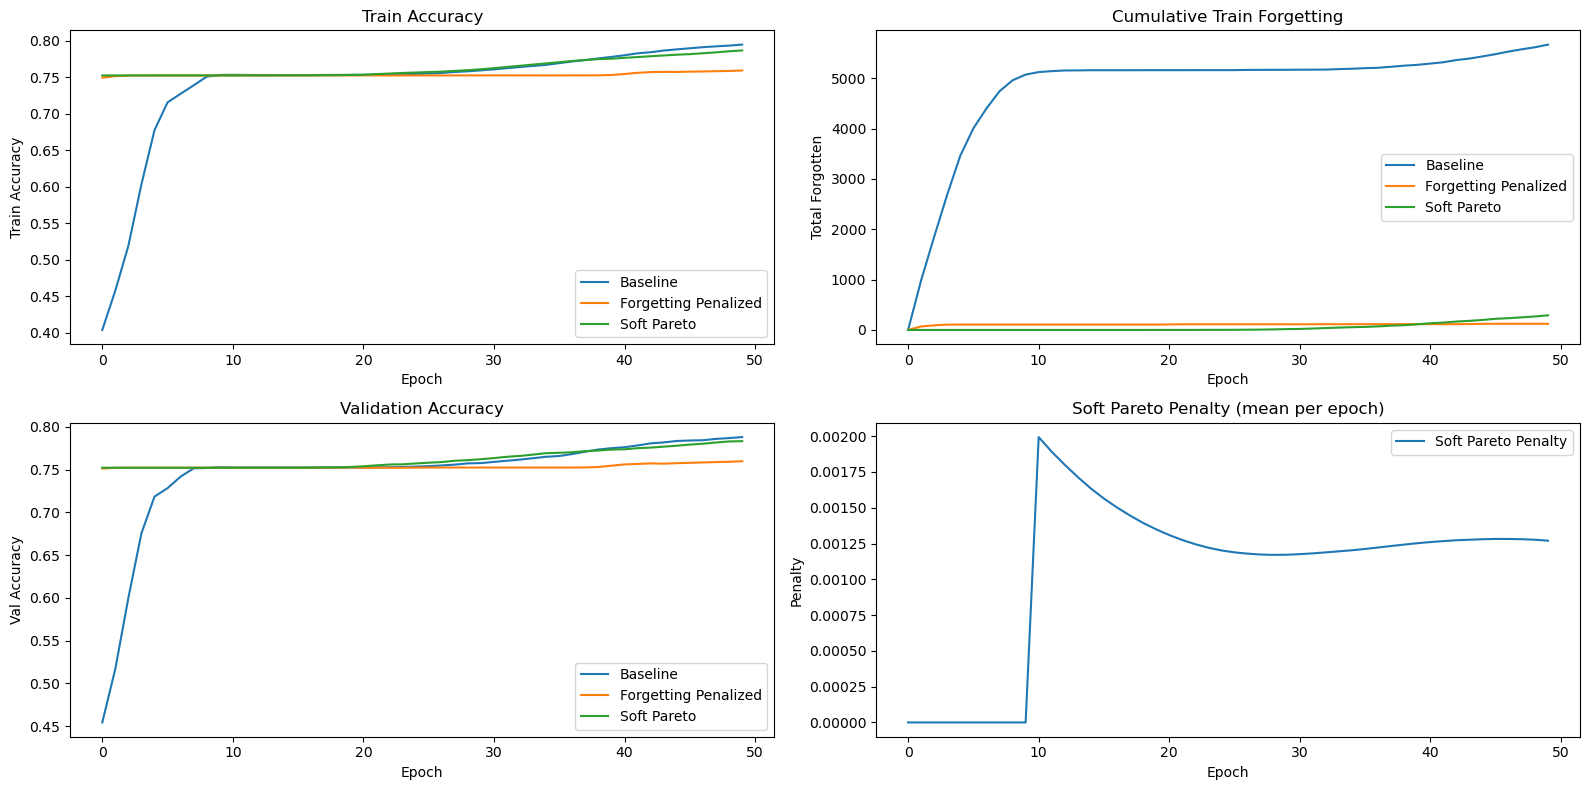


Total forgetting (train set):
  Baseline:        5668
  Penalized:       122
  Soft Pareto:     290

Final train accuracy:
  Baseline:        0.794
  Penalized:       0.759
  Soft Pareto:     0.786

Final validation accuracy:
  Baseline:        0.788
  Penalized:       0.760
  Soft Pareto:     0.783


In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Load Adult Data ---
def load_adult():
    data = fetch_openml("adult", version=2, as_frame=True)
    df = data.frame.dropna()
    X = pd.get_dummies(df.drop('class', axis=1))
    y = (df['class'] == '>50K').astype(int)
    X = X.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    return (torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(X_val, dtype=torch.float32),
            torch.tensor(y_train.values, dtype=torch.float32),
            torch.tensor(y_val.values, dtype=torch.float32))

X_train, X_val, y_train, y_val = load_adult()

# --- Model ---
class MLP(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(D, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): 
        return torch.sigmoid(self.net(x)).squeeze()

# --- Baseline Training ---
def run_training_baseline(epochs=50, lr=0.0008):
    model = MLP(X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()
    train_accs, forgetting_events, val_accs = [], [], []
    prev_train_correct = None
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        train_pred_labels = (y_pred > 0.5).float()
        train_correct = (train_pred_labels == y_train).float()
        train_accs.append(train_correct.mean().item())
        # Forgetting: correct→incorrect transitions
        if prev_train_correct is None:
            forgetting = 0
        else:
            forgetting = int(((prev_train_correct == 1) & (train_correct == 0)).sum().item())
        forgetting_events.append(forgetting)
        prev_train_correct = train_correct.clone()
        # Backprop
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        # Validation accuracy
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_pred_labels = (y_val_pred > 0.5).float()
            val_acc = (val_pred_labels == y_val).float().mean().item()
            val_accs.append(val_acc)
    return train_accs, forgetting_events, val_accs

# --- Forgetting-Penalized Training (Your Proposal) ---
def run_training_forgetting_penalized_on_train(
    base_penalty=0.1, max_penalty=0.5, warmup_epochs=10, epochs=50, lr=0.0008
):
    model = MLP(X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()
    prev_train_correct = None
    ever_forgotten = torch.zeros_like(y_train)
    train_accs, forgetting_events, val_accs = [], [], []
    for epoch in range(epochs):
        # ADAPTIVE penalty schedule
        if epoch < warmup_epochs:
            penalty_lambda = 0.0
        else:
            progress = (epoch - warmup_epochs) / max(1, (epochs - warmup_epochs))
            penalty_lambda = base_penalty + (max_penalty - base_penalty) * progress

        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        train_pred_labels = (y_pred > 0.5).float()
        train_correct = (train_pred_labels == y_train).float()
        train_accs.append(train_correct.mean().item())
        # Forgetting: correct→incorrect transitions on train set
        if prev_train_correct is None:
            forgetting = 0
            forget_mask = None
        else:
            forget_mask = ((prev_train_correct == 1) & (train_correct == 0) & (ever_forgotten == 0))
            forgetting = int(forget_mask.sum().item())
        forgetting_events.append(forgetting)
        # Update ever_forgotten
        if prev_train_correct is not None and forget_mask is not None:
            ever_forgotten = ever_forgotten.clone()
            ever_forgotten[forget_mask] = 1
        # Penalize forgetting on train set
        forget_penalty = torch.tensor(0.0)
        if (
            prev_train_correct is not None
            and forget_mask is not None
            and forget_mask.sum() > 0
            and penalty_lambda > 0
        ):
            forget_penalty = loss_fn(y_pred[forget_mask], y_train[forget_mask])
            total_loss = loss_fn(y_pred, y_train) + penalty_lambda * forget_penalty
        else:
            total_loss = loss_fn(y_pred, y_train)
        total_loss.backward()
        optimizer.step()
        prev_train_correct = train_correct.clone()
        # Validation accuracy
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_pred_labels = (y_val_pred > 0.5).float()
            val_acc = (val_pred_labels == y_val).float().mean().item()
            val_accs.append(val_acc)
    return train_accs, forgetting_events, val_accs

# --- Soft Pareto Training ---
def run_training_soft_pareto(
    base_penalty=0.1, max_penalty=0.5, warmup_epochs=10, epochs=50, lr=0.0008
):
    model = MLP(X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss(reduction='none')
    train_accs, forgetting_events, val_accs, pareto_penalties = [], [], [], []
    prev_train_loss = None
    prev_train_correct = None
    for epoch in range(epochs):
        # ADAPTIVE penalty schedule
        if epoch < warmup_epochs:
            penalty_lambda = 0.0
        else:
            progress = (epoch - warmup_epochs) / max(1, (epochs - warmup_epochs))
            penalty_lambda = base_penalty + (max_penalty - base_penalty) * progress

        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        per_ex_loss = loss_fn(y_pred, y_train)
        train_pred_labels = (y_pred > 0.5).float()
        train_correct = (train_pred_labels == y_train).float()
        train_accs.append(train_correct.mean().item())
        # Forgetting: correct→incorrect transitions on train set
        if prev_train_correct is None:
            forgetting = 0
        else:
            forgetting = int(((prev_train_correct == 1) & (train_correct == 0)).sum().item())
        forgetting_events.append(forgetting)
        # Soft Pareto penalty: penalize any increase in per-example loss
        pareto_penalty = torch.tensor(0.0)
        if prev_train_loss is not None and penalty_lambda > 0:
            loss_increase = torch.relu(per_ex_loss - prev_train_loss)
            pareto_penalty = loss_increase.mean()
            total_loss = per_ex_loss.mean() + penalty_lambda * pareto_penalty
        else:
            total_loss = per_ex_loss.mean()
        total_loss.backward()
        optimizer.step()
        prev_train_loss = per_ex_loss.detach()
        prev_train_correct = train_correct.clone()
        pareto_penalties.append(float(pareto_penalty))
        # Validation accuracy
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_pred_labels = (y_val_pred > 0.5).float()
            val_acc = (val_pred_labels == y_val).float().mean().item()
            val_accs.append(val_acc)
    return train_accs, forgetting_events, val_accs, pareto_penalties

# --- Run All Three ---
epochs = 50
train_acc_base, forget_base, val_acc_base = run_training_baseline(epochs=epochs)
train_acc_pen, forget_pen, val_acc_pen = run_training_forgetting_penalized_on_train(
    base_penalty=0.1, max_penalty=0.5, warmup_epochs=10, epochs=epochs
)
train_acc_pareto, forget_pareto, val_acc_pareto, pareto_penalty = run_training_soft_pareto(
    base_penalty=0.1, max_penalty=0.5, warmup_epochs=10, epochs=epochs
)

# --- Plot Results ---
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt.plot(train_acc_base, label="Baseline")
plt.plot(train_acc_pen, label="Forgetting Penalized")
plt.plot(train_acc_pareto, label="Soft Pareto")
plt.title("Train Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Train Accuracy"); plt.legend()

plt.subplot(2,2,2)
plt.plot(np.cumsum(forget_base), label="Baseline")
plt.plot(np.cumsum(forget_pen), label="Forgetting Penalized")
plt.plot(np.cumsum(forget_pareto), label="Soft Pareto")
plt.title("Cumulative Train Forgetting")
plt.xlabel("Epoch"); plt.ylabel("Total Forgotten"); plt.legend()

plt.subplot(2,2,3)
plt.plot(val_acc_base, label="Baseline")
plt.plot(val_acc_pen, label="Forgetting Penalized")
plt.plot(val_acc_pareto, label="Soft Pareto")
plt.title("Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Val Accuracy"); plt.legend()

plt.subplot(2,2,4)
plt.plot(pareto_penalty, label="Soft Pareto Penalty")
plt.title("Soft Pareto Penalty (mean per epoch)")
plt.xlabel("Epoch"); plt.ylabel("Penalty"); plt.legend()

plt.tight_layout()
plt.show()

# --- Print Summary ---
print("\nTotal forgetting (train set):")
print(f"  Baseline:        {sum(forget_base)}")
print(f"  Penalized:       {sum(forget_pen)}")
print(f"  Soft Pareto:     {sum(forget_pareto)}")

print(f"\nFinal train accuracy:")
print(f"  Baseline:        {train_acc_base[-1]:.3f}")
print(f"  Penalized:       {train_acc_pen[-1]:.3f}")
print(f"  Soft Pareto:     {train_acc_pareto[-1]:.3f}")

print(f"\nFinal validation accuracy:")
print(f"  Baseline:        {val_acc_base[-1]:.3f}")
print(f"  Penalized:       {val_acc_pen[-1]:.3f}")
print(f"  Soft Pareto:     {val_acc_pareto[-1]:.3f}")